In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost
from sklearn.model_selection import GroupKFold, KFold
import uuid
import seaborn as sns

In [2]:
train  = pd.read_pickle('Feat5_119_oct_1_feats_train.pkl')
test = pd.read_pickle('Feat5_119_oct_1_feats_test.pkl')

In [3]:
#train.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)
#test.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)

In [4]:
# train['duration'] = train['duration'].dt.days
# test['duration'] = test['duration'].dt.days

In [5]:
campaignData = pd.read_csv('campaign_data.csv')
campaignData['start_date'] = pd.to_datetime(campaignData['start_date'], format= '%d/%m/%y')
campaignData['end_date'] = pd.to_datetime(campaignData['end_date'], format= '%d/%m/%y')
campaignData = campaignData.sort_values(by = 'start_date')
testCamp = test.campaign_id.unique()
trainCamp = train.campaign_id.unique()
campaignData['TrainOrTest'] = campaignData['campaign_id'].apply(lambda x : 'Train' if x in trainCamp else 'Test')

In [6]:
train.info(max_cols= 200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 121 columns):
id                               78369 non-null int64
campaign_id                      78369 non-null int64
coupon_id                        78369 non-null int64
customer_id                      78369 non-null int64
redemption_status                78369 non-null int64
item_id_nunique                  78369 non-null int64
item_id_mode                     78369 non-null int64
quantity_mean                    78369 non-null float64
quantity_nunique                 78369 non-null int64
quantity_mode                    78369 non-null int64
quantity_std                     78369 non-null float64
quantity_max_                    78369 non-null int64
selling_price_mean               78369 non-null float64
selling_price_max_               78369 non-null float64
selling_price_min_               78369 non-null float64
selling_price_std                78369 non-null float64
other_discount

In [7]:
target = 'redemption_status'
cat = ['campaign_type', 'brand_type_mode', 'brand_type_category_mode', 'brand_category_mode', 
      'CoupBrandTypeMode', 'age_range', 'marital_status']

In [8]:
#moreCat = [x for x in train.columns if ('mode' in x.lower())]

In [9]:
#cat = list(set(cat + moreCat))

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
All = train.append(test)

In [12]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = cat
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))

In [13]:
for c in cat:
    lbe = LabelEncoder()
    All[c] = All[c].astype('str')
    All[c] = lbe.fit_transform(All[c])

In [14]:
#All, newCols = one_hot_encoder(All, nan_as_category=True)

In [15]:
# numColsToGroupBy = ['nUniqueCust', 'is_monthEnd_mean',
#        'is_monthStart_mean', 'selling_price_mean',
#        'is_coupoun_disc_mean', 'disc_perc_max_',
#        'itemPastTotalBillMin', 'Total_Bill_min_', 'itemPastOtherMean',
#        'itemPastSellingMean', 'selling_price_std', 'item_id_nunique',
#        'itemPastSellingMax', 'itemPastOtherStd', 'income_bucket_div_age',
#        'selling_price_max_', 'coupon_discount_std', 'disc_perc_mean',
#        'itemPastSellingStd', 'disc_perc_std', 'itemPastSellingMin']

# cat = ['coupon_id']

# def level_1_group_by_feats(df,cat,num):
#     df[cat+'_'+num+'_mean']=df[cat].map(dict(df.groupby([cat])[num].mean()))
#     df[cat+'_'+num+'_std']=df[cat].map(dict(df.groupby([cat])[num].std()))
#     df[cat+'_'+num+'_mean_delta']=df[num]- df[cat+'_'+num+'_mean']
#     df[cat+'_'+num+'_mean_ratio']=df[num]/ (1+df[cat+'_'+num+'_mean'])
#     return df

# combos=[(a,b) for a in numColsToGroupBy for b in cat]
# print(len(combos))
# for i,combo in enumerate(combos):
#     All=level_1_group_by_feats(All,combo[1],combo[0])
#     print(i)

In [16]:
train = All[~All.redemption_status.isnull()]
test = All[All.redemption_status.isnull()]

In [17]:
toDrop = [x for x in train.columns if train[x].nunique() == 1]

In [18]:
moreToDrop = [x for x in train.columns if x.startswith('Coup')]

In [19]:
notTrainOn = ['id', 'campaign_id']
trainOn = [x for x in train.columns if (x not in notTrainOn ) & (x not in toDrop) & (x!=target) & (x not in moreToDrop)]

In [20]:
gkf = KFold(n_splits=5)

In [21]:
catIndex = [i for i,x in enumerate(trainOn) if x in cat]

In [22]:
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()

In [23]:
def getResultSummary(res):
    trainMean = np.mean(list(map(lambda x : x[0], res)))
    validMean = np.mean(list(map(lambda x : x[1], res)))
    trainStd = np.std(list(map(lambda x : x[0], res)))
    validStd = np.std(list(map(lambda x : x[1], res)))
    return {
        
        'Train Mean' : trainMean, 
        'Valid Mean' : validMean, 
        'Train Std'  : trainStd,
        'Valid Std'  : validStd
    }

In [24]:
import lightgbm as lgb

In [25]:
results = []
featureImp = []
i = 0
for train_index, test_index in gkf.split(train[trainOn], train[target]):
    train_X = train.iloc[train_index][trainOn]
    valid_X = train.iloc[test_index][trainOn]
    train_y = train.iloc[train_index][target]
    valid_y = train.iloc[test_index][target]
    model = xgboost.XGBClassifier(n_estimators=3500, n_jobs=6, learning_rate=0.02, subsample=0.8, random_state=17, )
    model.fit(train_X, train_y, eval_set= [(train_X, train_y),
                                        (valid_X, valid_y)],
                            early_stopping_rounds= 100, verbose = 50, eval_metric = 'auc')
    valid_pred = model.predict_proba(valid_X)[:,1]
    train_pred = model.predict_proba(train_X)[:,1]
    trainRes = roc_auc_score(train_y, train_pred)
    validRes = roc_auc_score(valid_y, valid_pred)
    oof[test_index] = valid_pred
    ootPred = model.predict_proba(test[trainOn])[:,1]
    oot += ootPred / 5
    results.append((trainRes, validRes))
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = trainOn
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    i+=1

[0]	validation_0-auc:0.840162	validation_1-auc:0.850748
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.882383	validation_1-auc:0.897365
[100]	validation_0-auc:0.916396	validation_1-auc:0.915658
[150]	validation_0-auc:0.926817	validation_1-auc:0.92591
[200]	validation_0-auc:0.93567	validation_1-auc:0.932333
[250]	validation_0-auc:0.942384	validation_1-auc:0.933769
[300]	validation_0-auc:0.948497	validation_1-auc:0.94267
[350]	validation_0-auc:0.954777	validation_1-auc:0.947924
[400]	validation_0-auc:0.960145	validation_1-auc:0.950125
[450]	validation_0-auc:0.963723	validation_1-auc:0.952241
[500]	validation_0-auc:0.96704	validation_1-auc:0.954346
[550]	validation_0-auc:0.969772	validation_1-auc:0.95549
[600]	validation_0-auc:0.972064	validation_1-auc:0.956531
[650]	validation_0-auc:0.974335	validation_1-auc:0.957242
[700]	validation_0-auc:0.976131	valida

[350]	validation_0-auc:0.954887	validation_1-auc:0.949547
[400]	validation_0-auc:0.960142	validation_1-auc:0.951813
[450]	validation_0-auc:0.964941	validation_1-auc:0.954246
[500]	validation_0-auc:0.968259	validation_1-auc:0.956249
[550]	validation_0-auc:0.971256	validation_1-auc:0.957452
[600]	validation_0-auc:0.973539	validation_1-auc:0.958848
[650]	validation_0-auc:0.975744	validation_1-auc:0.959656
[700]	validation_0-auc:0.977641	validation_1-auc:0.961045
[750]	validation_0-auc:0.97892	validation_1-auc:0.961441
[800]	validation_0-auc:0.980286	validation_1-auc:0.961872
[850]	validation_0-auc:0.981456	validation_1-auc:0.962094
[900]	validation_0-auc:0.982561	validation_1-auc:0.962407
[950]	validation_0-auc:0.983523	validation_1-auc:0.96251
[1000]	validation_0-auc:0.984483	validation_1-auc:0.962795
[1050]	validation_0-auc:0.985398	validation_1-auc:0.962905
[1100]	validation_0-auc:0.986222	validation_1-auc:0.962736
Stopping. Best iteration:
[1033]	validation_0-auc:0.985042	validation_1

In [29]:
getResultSummary(results)

{'Train Mean': 0.9870862644738934,
 'Valid Mean': 0.9558594909873687,
 'Train Std': 0.004742157841062713,
 'Valid Std': 0.00910742982296578}

In [30]:
def saveStackingFile(prefix):
    oof_ = pd.DataFrame(oof,columns = [prefix])
    oot_ = pd.DataFrame(oot,columns = [prefix])
    print(oof_.shape, oot_.shape)
    oof_.to_csv(prefix + '_train.csv', index = False)
    oot_.to_csv(prefix + '_test.csv', index = False)

In [31]:
saveStackingFile('XGB_0.02_0.8_17_Feat_5_label_encoding_Coup_Removed')

(78369, 1) (50226, 1)


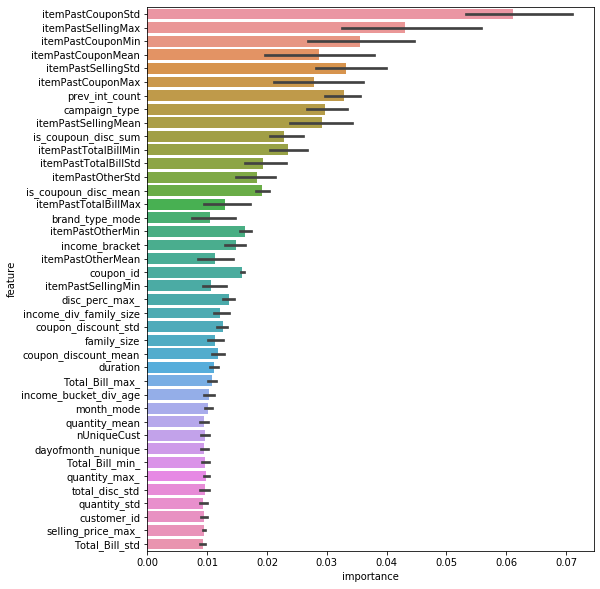

In [32]:
display_importances(feature_importance_df)

In [30]:
test[target] = oot

In [31]:
fileName = str(uuid.uuid4()).split('-')[-1]

In [32]:
test[['id', target]].to_csv(fileName + '.csv', index = False)